In [1]:
import numpy as np
import nltk
import pandas as pd
import collections
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive/")
df = pd.read_csv("/content/drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load pretrained model - google universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
def embed(input):
  return model(input)

In [4]:
#Seperate out Wellsfargo testset, remove null
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["EQUIFAX, INC.","TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE"]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_cu=df_cu.dropna()
df_banks=df_banks.dropna()
df_mortgages=df_mortgages.dropna()

In [5]:
# Get corpus and check size
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
print(len(cu_complaint),len(banks_complaint),len(mortgages_complaint),len(wells_complaint))

116421 58333 11374 17618


In [6]:
# Coding block to calculate pairwise similarity matrix
# This will take 10 minutes to embed and require around 15G memory
print("now embedding wells dataset")
# Embedding wells dataset
wells_embed=embed(wells_complaint)

print("now embedding cu dataset")
# Embedding cu dataset
cu_embed1=embed(cu_complaint[0:60000])
cu_embed2=embed(cu_complaint[60000:])
cu_embed=np.concatenate((cu_embed1,cu_embed2),axis=0)
del(cu_embed1)
del(cu_embed2)
#pairwise similarity
cu_wells_matrix=np.dot(wells_embed,tf.transpose(cu_embed))
#delete embedding and keep similarity matrix to save memory
del(cu_embed)

print("now embedding mortgages dataset")
# Embedding mortgages dataset
mortgages_embed=embed(mortgages_complaint)
#pairwise similarity
mortgages_wells_matrix=np.dot(wells_embed,tf.transpose(mortgages_embed))
#delete embedding and keep similarity matrix to save memory
del(mortgages_embed)

print("now embedding banks dataset")
# Embedding banks dataset
banks_embed1=embed(banks_complaint[0:30000])
banks_embed2=embed(banks_complaint[30000:])
banks_embed=np.concatenate((banks_embed1,banks_embed2),axis=0)
del(banks_embed1)
del(banks_embed2)
banks_wells_matrix=np.dot(wells_embed,tf.transpose(banks_embed))
del(banks_embed)

# Check pairwise similarity matrix shapes
print(cu_wells_matrix.shape,mortgages_wells_matrix.shape,banks_wells_matrix.shape)

now embedding wells dataset
now embedding cu dataset
now embedding mortgages dataset
now embedding banks dataset
(17618, 116421) (17618, 11374) (17618, 58333)


In [7]:
## Alternate pairwise similarity calculation by blocks to save memory

# def score(vendor,doc,v_size,d_size):
#   n_vendor=len(vendor)
#   n_doc=len(doc)
#   blocks_vendor=n_vendor//v_size
#   blocks_doc=n_doc//d_size
#   result=[]
#   for i in range(0,blocks_doc):
#     temp_doc=doc[i*d_size:(i+1)*d_size]
#     temp_doc_embed=embed(temp_doc)
#     temp_result=np.zeros(shape=(d_size,1))
#     for j in range(0,blocks_vendor):
#       temp_vendor=vendor[j*v_size:(j+1)*v_size]
#       temp_vendor_embed=embed(temp_vendor)
#       temp=np.inner(temp_doc_embed,temp_vendor_embed).max(axis=1).reshape(d_size,1)
#       temp_result=np.concatenate((temp_result,temp),axis=1)
#     if n_vendor%v_size!=0:
#       remain_vendor_size=n_vendor%v_size
#       remain_vendor=vendor[-remain_vendor_size:]
#       remain_vendor_embed=embed(remain_vendor)
#       temp=np.inner(temp_doc_embed,remain_vendor_embed).max(axis=1).reshape(d_size,1)
#       temp_result=np.concatenate((temp_result,temp),axis=1)
#     result.append(temp_result.max(axis=1))
#     print(f'Now running blocks {i} in {blocks_doc} total blocks')
#   if n_doc%d_size!=0:
#     remain_doc_size=n_doc%d_size
#     remain_doc=doc[-remain_doc_size:]
#     remain_doc_embed=embed(remain_doc)
#     temp_result=np.zeros(shape=(remain_doc_size,1))
#     for j in range(0,blocks_vendor):
#       temp_vendor=vendor[j*v_size:(j+1)*v_size]
#       temp_vendor_embed=embed(temp_vendor)
#       temp=np.inner(remain_doc_embed,temp_vendor_embed).max(axis=1).reshape(remain_doc_size,1)
#       temp_result=np.concatenate((temp_result,temp),axis=1)
#     if n_vendor%v_size!=0:
#       remain_vendor_size=n_vendor%v_size
#       remain_vendor=vendor[-remain_vendor_size:]
#       remain_vendor_embed=embed(remain_vendor)
#       temp=np.inner(remain_doc_embed,remain_vendor_embed).max(axis=1).reshape(remain_doc_size,1)
#       temp_result=np.concatenate((temp_result,temp),axis=1)
#     result.append(temp_result.max(axis=1))
#   output=np.concatenate(result)
#   return output

In [8]:
## Alternate pairwise similarity calculation by blocks to save memory
# cu_wells_top_similarity=score(cu_complaint,wells_complaint,10000,10000)
# mortgages_wells_top_similarity=score(mortgages_complaint,wells_complaint,10000,10000)
# banks_wells_top_similarity=score(banks_complaint,wells_complaint,10000,10000)

Approach 2.1 Similarity score with top N closeset sentence from vendor dataset

In [9]:
n_similarity=10 #Do not use n larger than 10 to save memory
cu_wells_top_similarity=np.sum(np.partition(cu_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
mortgages_wells_top_similarity=np.sum(np.partition(mortgages_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
banks_wells_top_similarity=np.sum(np.partition(banks_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
print(cu_wells_top_similarity.shape,mortgages_wells_top_similarity.shape,banks_wells_top_similarity.shape)

(17618,) (17618,) (17618,)


(array([  21.,   35.,   46.,   66.,   94.,  146.,  174.,  300.,  416.,
         637.,  794., 1026., 1388., 1595., 1835., 2022., 1887., 1746.,
        1320.,  904.,  540.,  282.,  136.,   19.,    8.,   10.,   16.,
           3.,   19.,   78.]),
 array([0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 ,
        0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82,
        0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ],
       dtype=float32),
 <a list of 30 Patch objects>)

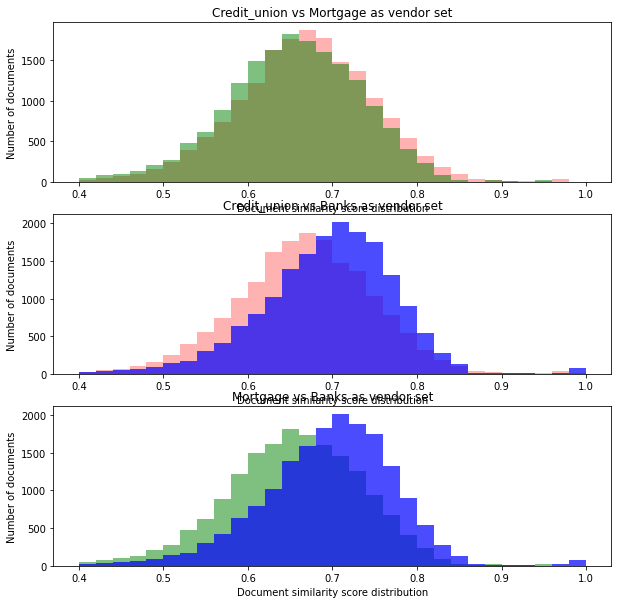

In [10]:
# Plot result distribution

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Credit_union vs Mortgage as vendor set")
ax[0].set_xlabel("Document similarity score distribution")
ax[0].set_ylabel("Number of documents")
ax[0].hist(cu_wells_top_similarity,alpha=0.3,bins=30,range=(0.4,1),color="red")
ax[0].hist(mortgages_wells_top_similarity,alpha=0.5,bins=30,range=(0.4,1),color="green")

ax[1].set_title("Credit_union vs Banks as vendor set")
ax[1].set_xlabel("Document similarity score distribution")
ax[1].set_ylabel("Number of documents")
ax[1].hist(cu_wells_top_similarity,alpha=0.3,bins=30,range=(0.4,1),color="red")
ax[1].hist(banks_wells_top_similarity,alpha=0.7,bins=30,range=(0.4,1),color="blue")

ax[2].set_title("Mortgage vs Banks as vendor set")
ax[2].set_xlabel("Document similarity score distribution")
ax[2].set_ylabel("Number of documents")
ax[2].hist(mortgages_wells_top_similarity,alpha=0.5,bins=30,range=(0.4,1),color="green")
ax[2].hist(banks_wells_top_similarity,alpha=0.7,bins=30,range=(0.4,1),color="blue")

Approach 2.2 Use define closes meaning sentence as cosine similarity >= some threshold, find number of close meaning sentence as document score


In [11]:
# Nearest neighbours
similarity_threshold=0.9
cu_wells_threshold_count=np.sum((cu_wells_matrix>=similarity_threshold),axis=1)
mortgages_wells_threshold_count=np.sum((mortgages_wells_matrix>=similarity_threshold),axis=1)
banks_wells_threshold_count=np.sum((banks_wells_matrix>=similarity_threshold),axis=1)

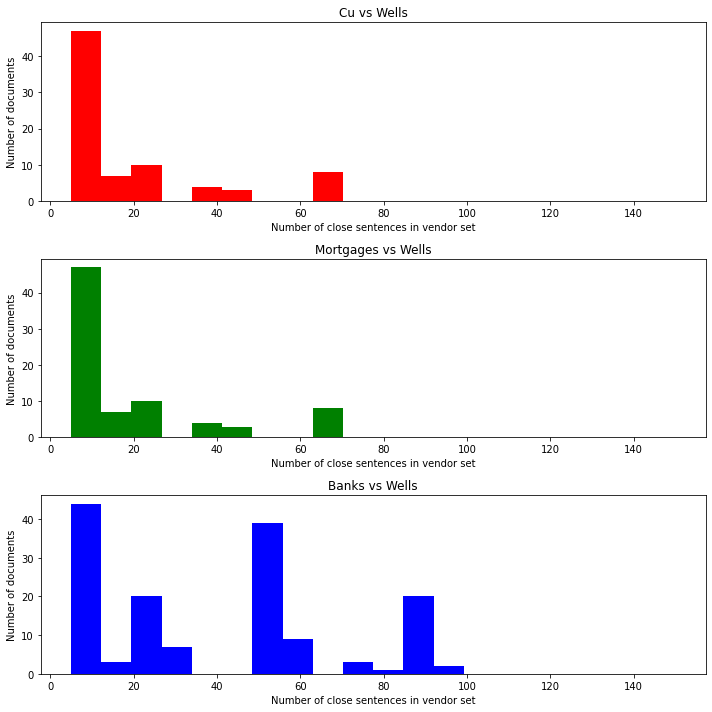

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Cu vs Wells")
ax[0].set_xlabel("Number of close sentences in vendor set")
ax[0].set_ylabel("Number of documents")
ax[0].hist(cu_wells_threshold_count,alpha=1,bins=20,range=(5,150),color="red")

ax[1].set_title("Mortgages vs Wells")
ax[1].set_xlabel("Number of close sentences in vendor set")
ax[1].set_ylabel("Number of documents")
ax[1].hist(cu_wells_threshold_count,alpha=1,bins=20,range=(5,150),color="green")

ax[2].set_title("Banks vs Wells")
ax[2].set_xlabel("Number of close sentences in vendor set")
ax[2].set_ylabel("Number of documents")
ax[2].hist(banks_wells_threshold_count,alpha=1,bins=20,range=(5,150),color="blue")

plt.tight_layout()
plt.show()